## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [11]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [12]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("/content/movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [13]:
df.head()  # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

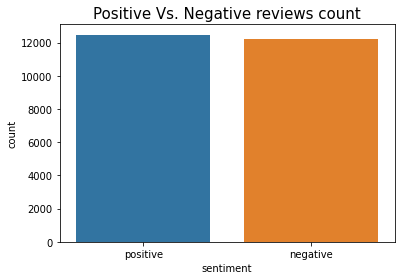

In [14]:
plt.figure(figsize = None)
sns.countplot(df['sentiment'])
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()

## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [15]:
df['sentiment'].value_counts()

positive    12474
negative    12225
Name: sentiment, dtype: int64

In [16]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df.iloc[(df.sentiment == 'positive').values]
df_minority = df.iloc[(df.sentiment == 'negative').values]

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [17]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled['sentiment'] == 'negative'].shape

(12474, 2)

In [18]:
df_upsampled['sentiment'].value_counts()

positive    12474
negative    12474
Name: sentiment, dtype: int64

### Expected Output : 
(12474, 2)

In [19]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled['sentiment'] == 'positive'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [20]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])


In [21]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

positive    10000
negative    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [22]:
y_test.value_counts()

positive    2474
negative    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [23]:
import string
import nltk
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
# TASK CELL

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    lower_text = review.lower()
    punctuationfree ="".join([i for i in lower_text if i not in string.punctuation])
    words = re.split(' ', punctuationfree)
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    review_cleaned = ' '.join(words) 


    return review_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [25]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n=0
    key_in_freqs=(word,label)
    if (key_in_freqs in frequency):
        n= frequency[key_in_freqs]

    return n 

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [26]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [27]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

0    10000
1    10000
Name: sentiment, dtype: int64

In [28]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'some people think that the second series was where scooby was ruined..i disagree totally.the shows quality did not go up or down and scrappy ,win my opinion,as a very good chrecter.i looked at a poll on jumpedtheshark.com and 72% of people said scrappys second series was scoobys downfall.OK so loads said yes but 28%still cant be wrong.I do like the way most of the episodes focused on comedy.i believe the show would have gone rubbish if it was the same 5 people/dog solving mystery in same formula.scrappy was a breath of fresh air to the show.sure,some people tuned out but when scrappy was introduced viewing figures DOUBLED.Back to the show.All the episodes and segments were very funny.i was Intriguded by the yabba shorts and .But at the end of the day its a matter of opinion if you like scrappy or not is a matter of opinion,there is certainly no fact involved.But in my OPINION this was a superb series that gave a beginning to tire show a new formula and lease of life.Nuff said.'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [29]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

people think second series scooby ruinedi disagree totallythe show quality go scrappy win opinionas good chrecteri looked poll jumpedthesharkcom 72 people said scrappys second series scoobys downfallok load said yes 28still cant wrongi like way episode focused comedyi believe show would gone rubbish 5 peopledog solving mystery formulascrappy breath fresh air showsuresome people tuned scrappy introduced viewing figure doubledback showall episode segment funnyi intriguded yabba short end day matter opinion like scrappy matter opinionthere certainly fact involvedbut opinion superb series gave beginning tire show new formula lease lifenuff said


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [30]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    output_occurrence = {}
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:

        pair = (word, label)
        if pair in output_occurrence:
          output_occurrence[pair] += 1
        else:
          output_occurrence[pair] = 1

    return output_occurrence

### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [31]:
# Testing your function

reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter({},reviews, ys)

{('bored', 1): 2,
 ('complete', 1): 1,
 ('enjoyed', 0): 1,
 ('fantastic', 0): 1,
 ('fullest', 0): 1,
 ('got', 1): 1,
 ('money', 1): 1,
 ('movie', 0): 2,
 ('moview', 1): 1,
 ('throught', 1): 1,
 ('time', 1): 1,
 ('waste', 1): 1,
 ('watch', 1): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [32]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [33]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('people', 0): 3513,
 ('think', 0): 2985,
 ('second', 0): 834,
 ('series', 0): 1526,
 ('scooby', 0): 15,
 ('ruinedi', 0): 1,
 ('disagree', 0): 77,
 ('totallythe', 0): 1,
 ('show', 0): 3805,
 ('quality', 0): 540,
 ('go', 0): 2743,
 ('scrappy', 0): 5,
 ('win', 0): 257,
 ('opinionas', 0): 1,
 ('good', 0): 5871,
 ('chrecteri', 0): 1,
 ('looked', 0): 251,
 ('poll', 0): 6,
 ('jumpedthesharkcom', 0): 1,
 ('72', 0): 6,
 ('said', 0): 791,
 ('scrappys', 0): 1,
 ('scoobys', 0): 1,
 ('downfallok', 0): 1,
 ('load', 0): 71,
 ('yes', 0): 540,
 ('28still', 0): 1,
 ('cant', 0): 1182,
 ('wrongi', 0): 2,
 ('like', 0): 7062,
 ('way', 0): 3445,
 ('episode', 0): 1150,
 ('focused', 0): 89,
 ('comedyi', 0): 2,
 ('believe', 0): 775,
 ('would', 0): 4149,
 ('gone', 0): 284,
 ('rubbish', 0): 26,
 ('5', 0): 269,
 ('peopledog', 0): 1,
 ('solving', 0): 20,
 ('mystery', 0): 339,
 ('formulascrappy', 0): 1,
 ('breath', 0): 82,
 ('fresh', 0): 211,
 ('air', 0): 256,
 ('showsuresome', 0): 1,
 ('tuned', 0): 17,
 ('introdu

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [34]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of messages
        train_y: a list of labels correponding to the messages (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set([key[0] for key in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 1:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos = freqs.get(pair)

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg = freqs.get(pair)

    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = (len(list(filter(lambda p:p>0,train_y))))

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = (len(list(filter(lambda p:p<=0,train_y))))

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs,word,1)
        freq_neg = find_occurrence(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)


    return logprior, loglikelihood

In [35]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
91965


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [36]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
    # process the review to get a list of words
    word_l = clean_review(review).split(' ')

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]

    if total_prob > 0:
      return 1
    else:
      return 0


In [37]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."

p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [49]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review,logprior,loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))
    correctly_classified = len(test_y) - np.sum(np.absolute(y_hats-test_y))
    
    accuracy = 1-error

    return accuracy, correctly_classified

In [39]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [40]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [41]:
#1 - spliting the dataset using sklearn and random_state = 0; where test_size = 20%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_upsampled['review'], df_upsampled['sentiment'], random_state=0, train_size = .8)

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19958,), (19958,), (4990,), (4990,))

In [42]:
# calculating frequencies for the training set
freqs_training = review_counter({}, X_train, y_train)
freqs_training

{('1977', 1): 19,
 ('cult', 1): 188,
 ('movie', 1): 22247,
 ('two', 1): 2470,
 ('crazed', 1): 50,
 ('lesbian', 1): 131,
 ('sandra', 1): 65,
 ('locke', 1): 4,
 ('colleen', 1): 2,
 ('camp', 1): 183,
 ('appearing', 1): 75,
 ('home', 1): 596,
 ('wealthy', 1): 49,
 ('socialite', 1): 6,
 ('doctor', 1): 323,
 ('george', 1): 267,
 ('manning', 1): 3,
 ('seymour', 1): 18,
 ('cassel', 1): 5,
 ('hope', 1): 606,
 ('help', 1): 726,
 ('locating', 1): 4,
 ('residence', 1): 18,
 ('cant', 1): 1823,
 ('seem', 1): 961,
 ('find', 1): 1758,
 ('plan', 1): 251,
 ('mind', 1): 812,
 ('wife', 1): 706,
 ('town', 1): 506,
 ('end', 1): 2498,
 ('taking', 1): 363,
 ('control', 1): 177,
 ('tying', 1): 7,
 ('killing', 1): 407,
 ('delivery', 1): 52,
 ('boy', 1): 689,
 ('destroying', 1): 39,
 ('place', 1): 1015,
 ('one', 1): 10448,
 ('evening', 1): 65,
 ('bizarre', 1): 192,
 ('disturbing', 1): 162,
 ('get', 1): 5195,
 ('reward', 1): 25,
 ('way', 1): 3209,
 ('either', 1): 905,
 ('dislike', 1): 56,
 ('right', 1): 1324,
 ('

In [43]:
#2 model parameters with training set
logprior, loglikelihood = train_naive_bayes(freqs_training, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0002004208845267641
91630


In [44]:
# confusion matrix for training set

y_train_pred = []
for review in X_train:
  y_train_pred.append(naive_bayes_predict(review, logprior, loglikelihood))

fp = 0
fn = 0
tp = 0
tn = 0

for actual_value, predicted_value in zip(y_train, y_train_pred):
    if predicted_value == actual_value: # t?
        if predicted_value == 1: # tp
            tp += 1
        else: 
            tn += 1
    else:
        if predicted_value == 1:
            fp += 1
        else: 
            fn += 1

confusion_matrix_training = [
    [tn, fp],
    [fn, tp]
]
confusion_matrix_training

[[9303, 675], [437, 9543]]

In [45]:
# confusion matrix for test set

y_test_pred = []
for review in X_test:
  y_test_pred.append(naive_bayes_predict(review, logprior, loglikelihood))

fp = 0
fn = 0
tp = 0
tn = 0

for actual_value, predicted_value in zip(y_test, y_test_pred):
    if predicted_value == actual_value: # t?
        if predicted_value == 1: # tp
            tp += 1
        else: 
            tn += 1
    else:
        if predicted_value == 1:
            fp += 1
        else: 
            fn += 1

confusion_matrix_test = [
    [tn, fp],
    [fn, tp]
]
confusion_matrix_test

[[2194, 302], [260, 2234]]

In [50]:
# testing accuracy
test_naive_bayes(X_test, y_test, logprior, loglikelihood)

(0.887374749498998, 4428)

4. The term "false positive" refers to a situation in which a review is labeled as positive but is not genuinely positive. Similarly, a false negative occurs when a review is incorrectly labeled as negative.

- Sometimes a review is a positive but one word which has very high accuracy in our dictionary (freq in our case) as a negative review. Therefore, while summing up all the probabilities this single world can generate the negative output. Hence positive review can be predicted as a negative, which is also known as false negative. Similarly, the false positive can also occur in the model in opposite manner.


# Q8. Modularize your calssifier (10 points)

> Indented block


1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

1.Laplace smoothing, also known as additive smoothing, is a smoothing technique used in Naive Bayes to solve the problem of zero probability. Let's pretend we have a dataset partitioned into train set and test test, and the Naive Bayes algorithm is trained on the train set by determining the frequency of each word in the train set. Consider the case when certain words are present in the test set but not in the train set; we don't have the probability of such terms. Because we multiply the likelihoods, if the likelihood of one word is zero, the probability will also be 0, which is not prefarable. We used Laplace smoothing to get around this.

Example: Let's assume the training document as : "The movie was fantastic and the cast was amazing" and assume that it is a positive i.e 1.

If the test document is as follows: " I am Shivam and actors were not good" and if the output is a negative review i.e 1. When we compute the probabilities of above test document then the train_data doesn't have the word 'Shivam','actors' and we get a zero probability for that word which would result to undersirable outcome.

So there's a chance that a big number of words are present in test data but not in train data, and we can avoid receiving a zero probability using the Naive Bayes method by applying laplace smoothing.

2.We compute logarithmic values rather than probability values because when we calculate the joint likelihood for a set, the total likelihood is the product of all likelihoods, whereas the sum of log-likelihood is less expensive than multiplication (although it is the same now a days). However, the fundamental problem is that the chances would become extremely tiny, and we would shortly run out of floating point accuracy, resulting in an underflow or information loss. That is why using log-likelihoods would be beneficial.